# Notes for the steady-state case (which we won't do)

## The $\sigma_{XXX}^2$ priors

### Power levels and marginal variances

Define the power of a vector $v$ as $$\mathcal{P}(v) = \frac{1}{N} \sum_{n=1}^N v_n^2.$$
(Alternative notation in line with Bretthorst (1988) is $\bar{v^2}$).
This corresponds to the marginal variance of a GP.
For example, $f_t \sim GP(0,k)$ where $k(t,t) = \sigma_t^2$ (marginal variance).
Then $$E[\int_0^T dt |f_t(t)|^2] = \sigma_t^2 T.$$
But also $$\int_0^T dt |f_t(t)|^2 \approx \sum_n |f_{t,n}|^2 \Delta = \mathcal{P}(f_t) T,$$ so $\mathcal{P}(f_t) \approx \sigma_t^2.$

### The $\sigma_{XXX}^2$ priors

The data is comprised of three signals: 'polar' (p) [used to be called 'periodics'], trend (t) and noise (n):

$$ d(t) = f(t) + n(t) = f_p(t) + f_t(t) + n(t) $$

Each of these 3 signals $(f_p,f_t,n)$ has a characteristic power level $(\sigma_p^2, \sigma_t^2, \sigma_n^2)$ and associated signal-to-XXX ratio (SPR, STR, SNR).
We need to set a prior for $\sigma_p^2$, $\sigma_t^2$ and $\sigma_n^2$.
These priors are based on earlier experience with the polynomial model.

Assume the unit power convention $\mathcal{P}(d) := 1$ by rescaling $d(t)$. This allows us to set scales for the other power levels:
- In the experiments, $\sigma_p^2 \sim O(1)$, $\sigma_t^2 \sim O(1)$, so we just set them to $1/2$ each.
This follows from the following: We have $$|d|^2 \simeq |f_p + f_t|^2 = |f_p|^2 + |f_t|^2 + 2 f_p \cdot f_t \approx |f_p|^2 + |f_t|^2$$ where we assumed the trend and polar components to be orthogonal to each other.
Dividing by $N$, this implies $$\mathcal{P}(d) = 1 \approx \mathcal{P}(f_p) + \mathcal{P}(f_t),$$ so it is reasonably to assign $1/2$ to them each.
This means SPR = STR = 3 dB.
- From LPC gain and experiments we know that SNR $\sim$ 20 dB, so $\sigma_n^2 \sim O(0.01)$.

Note: there is yet another power level: the noise floor $\delta_n^2$ at -60 dB (or -80 dB, can't remember).

#### More about $\sigma_p^2$ and $\sigma_t^2$

- If the trend is wobbly, the inproduct with the polar comonponent can be non-neglible and our assumption of orthogonal trend and polar components breaks (cosine angles of $\sim \pm O(0.5) \neq 0$). But things never go too crazy so just assigning $1/2$ will probably be OK.
- We tried to do clever things with the Schwarz inequality but it is not particularly helpful here.
[Given that $\mathcal{P}(d) = 1$, you can show that approximately $1 \leq \sqrt{\mathcal{P}(f_p)} + \sqrt{\mathcal{P}(f_t)}$, but this is not too helpful.]
- We can also parametrize these power levels but we just set them here, since our naieve approach with the polynomials worked fine.

### 'Polar'?

We contemplated several words for the signal component associated with the poles but finally decided on 'polar', because it is short and to the point, despite other associations it might bring.
'Polar' means that this component represents the poles of the system.
Here are some alternatives which we considered:
- 'resonant': No, because *both* the waveforms of the polar and trend components can, strictly, be said to be due to the resonant filter of the VT. It does not uniquely qualify the polar component.
- 'oscillatory': Nice word, but too long, and O subscript looks like a zero.
- 'periodical': The trend is also quasi-periodic at the pitch period level. It does not uniquely qualify the polar component.
- 'sinusoidal': Nice word, but too long, and in the GP approximations both the trend and polar components are represented by sinusoids. It does not uniquely qualify the polar component.

## Current questions

### Solved

- What is the complexity of the old algorithm (i.e., the one we use in `paretochain`)?
  * Answer: $O(N_P \times (NM + NM^2))$, where $N_P = \text{number of pitch periods}$, $N \sim O(80)$ is number of data points in a pitch periods, and $M \sim O(40)$ is the total number of basis functions ($K = 16$). $NM$ comes from calculating $G$ and $NM^2$ from the SVD to find the least-squares amplitudes.
- What is the complexity of the new algorithm? (Bretthorst 1991)
  * Answer: $O(N_P \times (NM + M^2 + M^3))$ where $NM$ comes from the projection $G^T d$, $M^2$ comes from calculating $g = G^T G$ analytically and $M^3$ from Cholesky of $g$. Since for us $M = 0(40) ~ N = O(80)$, the dominant cost is $O(M^3)$, so in principle (and in practice) faster than the old algorithm.
  * Because the projection $G^T$ can be done with $K + 1$ FFTs, in principle $G$ never even needs to be formed! However, overhead in Python is so large anyway (not to mention the overhead in dynesty's nested sampling loop alone) that we cannot really exploit the benefits of this.
- $M$ can be set statically from $f_s$ and $\ell$, since we choose $\ell$ fixed based on the pitch period $T$ (namely set to one expected zero crossing).
Value of $M$ can be derived from the constraint that we don't want frequencies higher than the glottal formant (right?), i.e., decide in advance on the bandwidth of the trend component. Probably something like $[0,150]$ Hz.
  * For $x_\max = 200$ Hz, $M \sim O(5)$. For $x_\max = 10$ kHz, $M \sim O(128)$. So in both cases this accords with what we thought intuitively before!
  * If this doesn't work: value of $M$ can be derived from $f_s$ because after a certain value of $M$ the $\sin()$ basis has power outside the Nyquist bandwidth. This depends on the lengthscale $\ell$, so $M$ could be made adaptive. Makes sense because $M$ controls wigglyness, and maximum wigglyness observable is controlled by $f_s$
- Might have to disable JAX for speed: yes

### Todo

- "Relaxation" of the Pareto chain prior? Model it by nonlinear whitening (MVN => softclip => exp) so the nested samplers are not stuck at the boundaries. And this prior breaks the invariance of the posterior. Sell it as a pragmatic position that can result in a strong speedup because no *strict* ordering is imposed -- just jinted at (and note that we also don't have to reject samples that are larger than $f_s$ anymore, also resulting in speedup).
- Talk about the fact that the FT can be misleading if low frequencies are present, and this is exactly the case we are working with. We also said this in the conference paper (Van Soom 2019a).
- Does our new prior eventually turn out like the old ones: $\sim N(0, \delta^2 I)$? Because that worked well.
- Steady state model: expand RBF with Hilbert and simplify $G^T G$ analytically
  * Trend component sinusoids will not be orthogonal because we don't evaluate on $[0,L]$ (i.e., $c \neq 1$). But we can still represent them as a phased sinusoid $\sin(\lambda t + \phi)$, so Bretthorst's (IV) formula's will still apply because we expand the phased sinusoid in $\sin$ and $\cos$ components.
- Steady state model: fixed expansion order $K$ is OK because of amplitude $\sim N(0,\sigma^2)$ representation. So excessive poles will be suppressed automatically by having zero amplitude. But this argument cannot be made when using an all-pole transfer function representation as in the semiparametric joint inverse filtering.

In [1]:
%run init.ipy

In [2]:
from scipy.special import loggamma

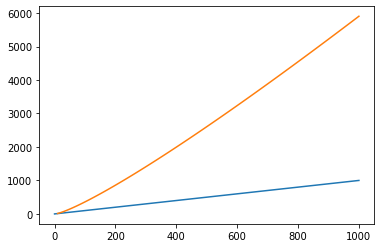

In [5]:
x = linspace(0, 1000, 100)

plot(x,6*x)
plot(x,loggamma(x))